# Demo Data Input

Esse arquivo tem como objetivo Gerar um dataframe em pandas para facil acesso dos audios e bmp associados ao dataset Ballroom

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Conv1D,Dropout,Flatten,AvgPool1D,BatchNormalization,Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

#### Abertura do arquivo contendo anotações

In [2]:
xtree = et.parse("extendedballroom_v1.1.xml")
xroot = xtree.getroot()

#### Creação do Dataframe

In [3]:
dir_dataset="C:/TCC/BallRoomWAV/"
df_cols =['Ritmo','ID','BPM','Titulo']
rows = []
for node in xroot: 
    for song in node:
        s_rit=node.tag
        s_id=song.attrib.get("id")
        s_bpm=song.attrib.get("bpm")
        s_title=song.attrib.get("title")
        rows.append({"Ritmo": s_rit, "ID": s_id, "BPM": s_bpm, "Titulo": s_title})
        
df = pd.DataFrame(rows, columns = df_cols)

In [4]:
df

,Ritmo,ID,BPM,Titulo
0,Waltz,100601,87,Morning Song
1,Waltz,100603,87,Wednesday's Child
2,Waltz,100602,87,Pastorale
3,Waltz,100604,87,Theme from Thornbirds
4,Waltz,101001,84,The Inner Light
...,...,...,...,...
4175,Wcswing,116914,120,Chain of Fools
4176,Wcswing,116916,120,Cowboy Casanova
4177,Wcswing,116918,120,The Wanderer
4178,Wcswing,116920,128,Blue (Da Ba Dee)


In [5]:
df.describe()

,Ritmo,ID,BPM,Titulo
count,4180,4180,4180,4180
unique,13,4180,85,3613
top,Waltz,117610,100,Espana Cani
freq,529,1,473,14


### Create Mel-Spec for one sample of dataset

In [6]:
n=10

path_file=dir_dataset+df.iloc[n]['Ritmo']+'/'+df.iloc[n]['ID']+'.wav'
print(path_file)

C:/TCC/BallRoomWAV/Waltz/101901.wav


#### Plot Time Series

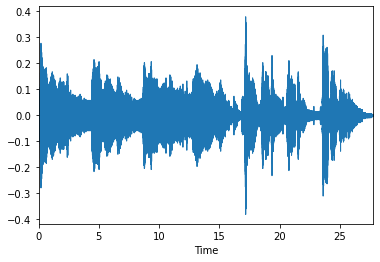

In [7]:
y, sr = librosa.load(path_file)
# trim silent edges
song, _ = librosa.effects.trim(y)
librosa.display.waveplot(song, sr=sr)

#### Plot FFT Spec

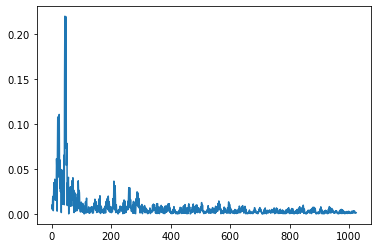

In [8]:
n_fft = 2048
D = np.abs(librosa.stft(song[:n_fft], n_fft=n_fft,hop_length=n_fft+1))
plt.plot(D)

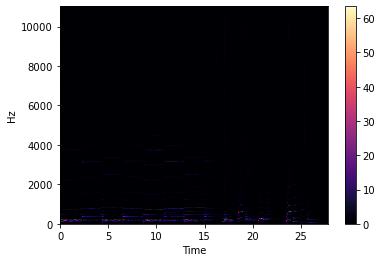

In [9]:
hop_length = 512
D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

### STFT in DB

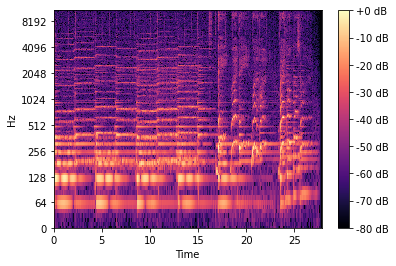

In [10]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

### Mel Spectrum in DB

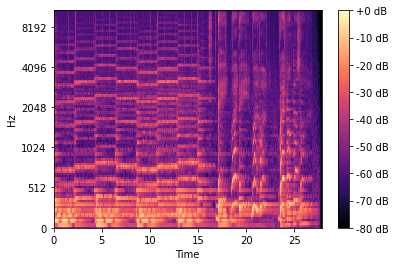

In [11]:
n_mels = 128
S = librosa.feature.melspectrogram(song, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

## Test with article parameters

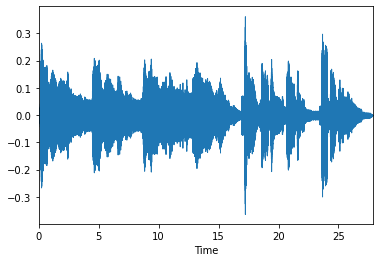

In [12]:
y, sr = librosa.load(path_file, sr=11025)
# trim silent edges
song, _ = librosa.effects.trim(y)
librosa.display.waveplot(song, sr=sr)

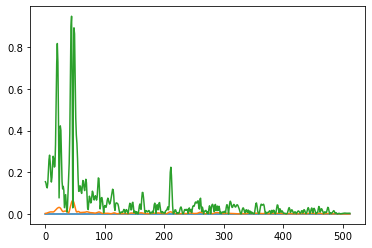

In [13]:
n_fft = 1024
D = np.abs(librosa.stft(song[:n_fft], n_fft=n_fft,hop_length=n_fft//2))
plt.plot(D)

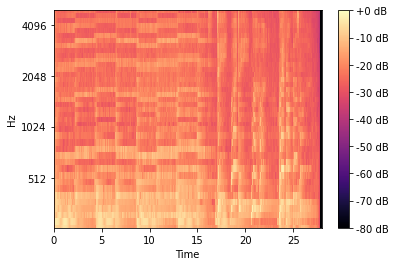

In [14]:
n_mels = 40
n_fft=1024
hop_length=512
S = librosa.feature.melspectrogram(song, sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length,power=1, 
                                   n_mels=n_mels,fmin=20, fmax=5000)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel',fmin=20, fmax=5000);
plt.colorbar(format='%+2.0f dB');

In [15]:
np.shape(S)

(40, 602)

In [16]:
S[:,10]

array([0.28219977, 0.5852438 , 0.34550264, 0.14577463, 0.2607293 ,
       0.12974583, 0.03445103, 0.04344349, 0.02574879, 0.02694515,
       0.02423179, 0.08021946, 0.00497853, 0.01444522, 0.04091946,
       0.0071135 , 0.00858945, 0.01237643, 0.00752499, 0.01103621,
       0.00293974, 0.01758968, 0.01622373, 0.00782499, 0.00601741,
       0.00878475, 0.00612888, 0.0251103 , 0.01713686, 0.00732302,
       0.00534395, 0.00618962, 0.01385841, 0.00429053, 0.00426095,
       0.00861206, 0.01006702, 0.00342732, 0.00505646, 0.00486918],
      dtype=float32)

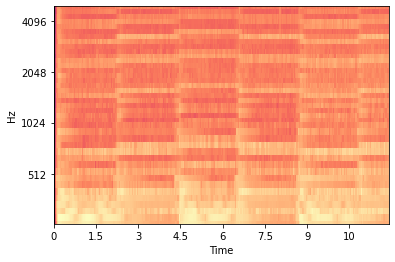

In [17]:
librosa.display.specshow(S_DB[:,:256], sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel',fmin=20, fmax=5000);

#### Preparing the database

In [18]:
df

,Ritmo,ID,BPM,Titulo
0,Waltz,100601,87,Morning Song
1,Waltz,100603,87,Wednesday's Child
2,Waltz,100602,87,Pastorale
3,Waltz,100604,87,Theme from Thornbirds
4,Waltz,101001,84,The Inner Light
...,...,...,...,...
4175,Wcswing,116914,120,Chain of Fools
4176,Wcswing,116916,120,Cowboy Casanova
4177,Wcswing,116918,120,The Wanderer
4178,Wcswing,116920,128,Blue (Da Ba Dee)


In [19]:
classes = list(np.unique(df.BPM))
classes_dist = df.groupby(['BPM'])['ID'].count()
prob_dist = classes_dist/len(df)

In [20]:
X_list = []
Y = []
_min,_max= float('inf'), -float('inf')
n_samples=len(df)
n_mels = 40
n_fft=1024
hop_length=512
samples_step=130560
for _ in tqdm(range(n_samples)):
    rand_class = np.random.choice(classes_dist.index,p=prob_dist)
    id_file =  np.random.choice(df[df.BPM==rand_class].index)
    path_file=dir_dataset+df.iloc[id_file]['Ritmo']+'/'+df.iloc[id_file]['ID']+'.wav'
    label=df.iloc[id_file]["BPM"]
    wav, sr = librosa.load(path_file, sr=11025)
    rand_index=np.random.randint(0,wav.shape[0]-samples_step)
    sample=wav[rand_index:rand_index+samples_step]
    X_sample = librosa.feature.melspectrogram(sample, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                              power=1, n_mels=n_mels,fmin=20, fmax=5000)
    X_sample_DB = librosa.power_to_db(X_sample, ref=np.max)
    _min=min(np.amin(X_sample_DB), _min)
    _max=max(np.amax(X_sample_DB), _max)
    X_list.append(X_sample_DB.T)
    Y.append(classes.index(label))
       
X = np.array(X_list)
Y = np.array(Y)
X = (X - _min)/(_max - _min)
Y = to_categorical(Y, num_classes=len(classes))

print(X.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 4180/4180 [34:45<00:00,  2.00it/s]


(4180, 256, 40)


## Create Model ConvNet

In [21]:
"""Test to use GPU"""
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [22]:
band_melscale=40
nb_frame=256
nClasses=85

In [23]:
# Define model With Functional API
Input_Spec=Input(shape=(nb_frame,band_melscale),name='Mel-spectrogram')
conv1=Conv1D(16,(5),padding='same',strides=1,activation='relu',name='Conv1')(BatchNormalization()(Input_Spec))
conv2=Conv1D(16,(5),padding='same',strides=1,activation='relu',name='Conv2')(BatchNormalization()(conv1))
conv3=Conv1D(16,(5),padding='same',strides=1,activation='relu',name='Conv3')(BatchNormalization()(conv2))

#Define Multi Filter Module

BN=BatchNormalization()(AvgPool1D(pool_size=5)(conv3))
conv_32=Conv1D(24,(32),padding='same',strides=1,activation='relu')(BN)
conv_64=Conv1D(24,(64),padding='same',strides=1,activation='relu')(BN)
conv_96=Conv1D(24,(96),padding='same',strides=1,activation='relu')(BN)
conv_128=Conv1D(24,(128),padding='same',strides=1,activation='relu')(BN)
conv_192=Conv1D(24,(192),padding='same',strides=1,activation='relu')(BN)
conv_256=Conv1D(24,(256),padding='same',strides=1,activation='relu')(BN)
mid_conc=Concatenate()([conv_32,conv_64,conv_96,conv_128,conv_192,conv_256])
bottleneck_1=Conv1D(36,(1),padding='same',strides=1,activation='relu')(mid_conc)

BN2=BatchNormalization()(AvgPool1D(pool_size=2)(bottleneck_1))
conv_32_2=Conv1D(24,(32),padding='same',strides=1,activation='relu')(BN2)
conv_64_2=Conv1D(24,(64),padding='same',strides=1,activation='relu')(BN2)
conv_96_2=Conv1D(24,(96),padding='same',strides=1,activation='relu')(BN2)
conv_128_2=Conv1D(24,(128),padding='same',strides=1,activation='relu')(BN2)
conv_192_2=Conv1D(24,(192),padding='same',strides=1,activation='relu')(BN2)
conv_256_2=Conv1D(24,(256),padding='same',strides=1,activation='relu')(BN2)
mid_conc_2=Concatenate()([conv_32_2,conv_64_2,conv_96_2,conv_128_2,conv_192_2,conv_256_2])
bottleneck_2=Conv1D(36,(1),padding='same',strides=1,activation='relu')(mid_conc_2)

BN3=BatchNormalization()(AvgPool1D(pool_size=2)(bottleneck_2))
conv_32_3=Conv1D(24,(32),padding='same',strides=1,activation='relu')(BN3)
conv_64_3=Conv1D(24,(64),padding='same',strides=1,activation='relu')(BN3)
conv_96_3=Conv1D(24,(96),padding='same',strides=1,activation='relu')(BN3)
conv_128_3=Conv1D(24,(128),padding='same',strides=1,activation='relu')(BN3)
conv_192_3=Conv1D(24,(192),padding='same',strides=1,activation='relu')(BN3)
conv_256_3=Conv1D(24,(256),padding='same',strides=1,activation='relu')(BN3)
mid_conc_3=Concatenate()([conv_32_3,conv_64_3,conv_96_3,conv_128_3,conv_192_3,conv_256_3])
bottleneck_3=Conv1D(36,(1),padding='same',strides=1,activation='relu')(mid_conc_3)

BN4=BatchNormalization()(AvgPool1D(pool_size=2)(bottleneck_3))
conv_32_4=Conv1D(24,(32),padding='same',strides=1,activation='relu')(BN4)
conv_64_4=Conv1D(24,(64),padding='same',strides=1,activation='relu')(BN4)
conv_96_4=Conv1D(24,(96),padding='same',strides=1,activation='relu')(BN4)
conv_128_4=Conv1D(24,(128),padding='same',strides=1,activation='relu')(BN4)
conv_192_4=Conv1D(24,(192),padding='same',strides=1,activation='relu')(BN4)
conv_256_4=Conv1D(24,(256),padding='same',strides=1,activation='relu')(BN4)
mid_conc_4=Concatenate()([conv_32_4,conv_64_4,conv_96_4,conv_128_4,conv_192_4,conv_256_4])
bottleneck_4=Conv1D(36,(1),padding='same',strides=1,activation='relu')(mid_conc_4)


flat = Flatten()(BatchNormalization()(bottleneck_4))
drop1=Dropout(0.5,name='Dropout')(flat)
dense_1 = Dense(64, activation='relu')(drop1)
dense_2 = Dense(64, activation='relu')(BatchNormalization()(dense_1))

Output = Dense(nClasses, activation='softmax')(BatchNormalization()(dense_2))
#Create the Model
model = Model(inputs=Input_Spec, outputs=Output)

In [24]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Mel-spectrogram (InputLayer)    [(None, 256, 40)]    0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 40)      160         Mel-spectrogram[0][0]            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 256, 16)      3216        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 16)      64          Conv1[0][0]                      
______________________________________________________________________________________________

In [25]:
model.compile(loss="categorical_crossentropy", 
              optimizer='adam', 
              metrics=['acc'])

In [26]:
y_flat = np.argmax(Y,axis=1)
Balanced_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_flat),
                                                 y_flat)
print(Balanced_weights)

[ 0.12044027  0.35304054  1.08627859 56.48648649 56.48648649  2.17255717
 56.48648649 14.12162162  0.35526092 18.82882883 18.82882883  0.15604002
 18.82882883  1.82214473 56.48648649  0.56486486 28.24324324 18.82882883
  0.13136392  7.06081081 11.2972973   0.18399507 56.48648649 18.82882883
 56.48648649  4.34511435 28.24324324  5.64864865 28.24324324  7.06081081
 18.82882883  9.41441441  8.06949807  7.06081081 18.82882883 14.12162162
 56.48648649  3.76576577  2.82432432  1.08627859  8.06949807  0.28243243
  0.67245817  5.64864865  4.03474903  0.47467636  1.34491634 14.12162162
 56.48648649 14.12162162  7.06081081  0.14157014 56.48648649  0.53796654
  4.70720721 28.24324324  3.53040541 28.24324324  4.70720721 18.82882883
 14.12162162 28.24324324  0.28243243 14.12162162 28.24324324  0.15063063
  2.17255717  4.03474903  0.86902287 56.48648649 28.24324324 28.24324324
  0.43451143  3.13813814]


In [27]:
history = model.fit(X, Y, epochs=20, batch_size=32,shuffle=True, 
                    validation_split=0.1 ,class_weight=Balanced_weights)

Train on 3762 samples, validate on 418 samples
Epoch 1/20
3762/3762 [==============================] - 36s 10ms/sample - loss: 4.0651 - acc: 0.1191 - val_loss: 4.0211 - val_acc: 0.0861
Epoch 2/20
3762/3762 [==============================] - 32s 9ms/sample - loss: 3.1299 - acc: 0.2379 - val_loss: 3.8049 - val_acc: 0.1411
Epoch 3/20
3762/3762 [==============================] - 32s 9ms/sample - loss: 2.5719 - acc: 0.3246 - val_loss: 2.8149 - val_acc: 0.2177
Epoch 4/20
3762/3762 [==============================] - 33s 9ms/sample - loss: 2.2596 - acc: 0.4043 - val_loss: 2.3096 - val_acc: 0.3732
Epoch 5/20
3762/3762 [==============================] - 33s 9ms/sample - loss: 1.9909 - acc: 0.4646 - val_loss: 2.0016 - val_acc: 0.4904
Epoch 6/20
3762/3762 [==============================] - 33s 9ms/sample - loss: 1.7548 - acc: 0.5250 - val_loss: 1.8903 - val_acc: 0.5096
Epoch 7/20
3762/3762 [==============================] - 33s 9ms/sample - loss: 1.5116 - acc: 0.5848 - val_loss: 1.5388 - val_acc: 

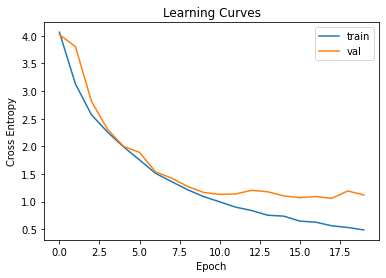

Test accuracy: 74.40191507339478 %


In [33]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("Test accuracy: " + str(float(history.history['val_acc'][-1]*100))+" %")

In [ ]:
"""
#to visualize Tensorboard logs write the command on anaconda prompt : tensorboard --logdir=log_path
#tensorboard --logdir="C:\TCC\logs\\
log_path="C:\TCC\logs\\"#Tensorboard Logs
tensorboard = TensorBoard(log_dir=log_path+'Test2'),histogram_freq=1)
tensorboard.set_model(model)"""